In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, display
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


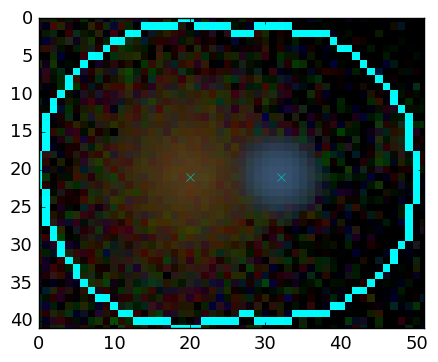

In [7]:
dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
filters = ["g","r", "i","z",'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
#display.plotColorImage(calexps=expDb.calexps, filterIndices=[2,1,0], contrast=1, figsize=(8,8));
#condition = expDb.mergedTable["peaks"]==4
condition = (expDb.mergedTable["peaks"]>=2) & (expDb.mergedTable["peaks"]<=5)# & (expDb.mergedTable["peaks"]<10)
footprint, peaks = expDb.getParentFootprint(parentIdx=0, condition=condition, contrast=1)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

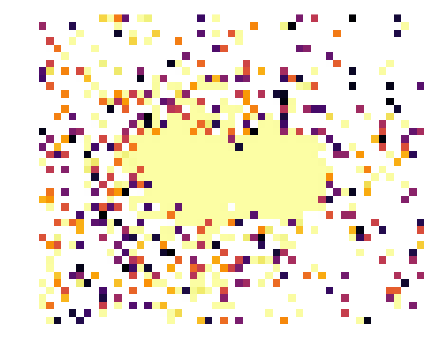

<module 'matplotlib.pyplot' from '/Users/fred/lsst/code/lsstswig2/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [47]:
xmin, xmax = deblend.bbox.getMinX(), deblend.bbox.getMaxX()
ymin, ymax = deblend.bbox.getMinY(), deblend.bbox.getMaxY()
variance = expDb.calexps[0].getMaskedImage().getVariance().getArray()
img = expDb.calexps[0].getMaskedImage().getImage().getArray()[ymin:ymax,xmin:xmax]
imgVar = variance[ymin:ymax,xmin:xmax]
display.maskPlot(img, vmax=1, mask=img<imgVar)

In [48]:
tbl = expDb.simTable
print(xmin, xmax, ymin, ymax)
matches = tbl[(tbl["x"]>xmin) & (tbl["x"]<xmax) & (tbl["y"]>ymin) & (tbl["y"]<ymax)]
matches

115 166 40 81


flux_g,flux_i,flux_r,flux_u,flux_y,flux_z,intensity_g [63001],intensity_i [63001],intensity_r [63001],intensity_u [63001],intensity_y [63001],intensity_z [63001],redshift,sed [260],size,star,wave [260],x,y
float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,int32,float32,float64,float64
3328.20968054,1631.93455,2442.98215879,448.669423701,532.292978507,1040.30051267,-8.6281e-06 .. 1.48947e-06,-4.23065e-06 .. 7.30336e-07,-6.33322e-06 .. 1.0933e-06,-1.16314e-06 .. 2.00792e-07,-1.37992e-06 .. 2.38216e-07,-2.69689e-06 .. 4.65563e-07,0.0,0.195784 .. 0.133697,0.0,1,200.0 .. 1495.0,146.739252207,60.6299536683
223.311793247,404.96757367,410.34145841,39.9793142337,201.201456788,336.004676549,0.000309817 .. 0.000113179,0.000561842 .. 0.000205246,0.000569298 .. 0.000207969,5.54663e-05 .. 2.02623e-05,0.000279142 .. 0.000101973,0.000466165 .. 0.000170294,0.374130061585,3.1175 .. 8.17994,32.6197116221,0,200.0 .. 1495.0,162.092465826,56.1592845803
1384.27341061,4264.72556093,3069.88301681,268.471175476,2364.47137266,3782.0020678,0.000598345 .. 0.000132641,0.0018434 .. 0.000408645,0.00132694 .. 0.000294156,0.000116045 .. 2.57249e-05,0.00102203 .. 0.000226563,0.00163475 .. 0.000362391,0.531337232741,17.2955 .. 95.2137,13.7304229464,0,200.0 .. 1495.0,134.981830307,60.6723839165


/Users/fred/lsst/code/lsstswig2/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


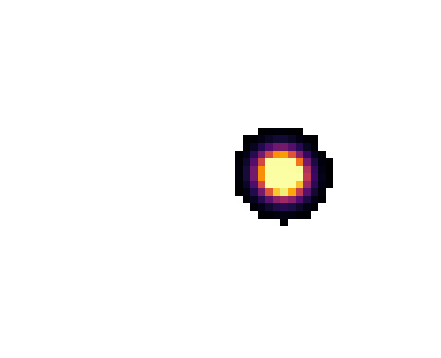

INFO:lsst.meas.deblender:Total flux: 3328.2097168, max flux: 139.604034424


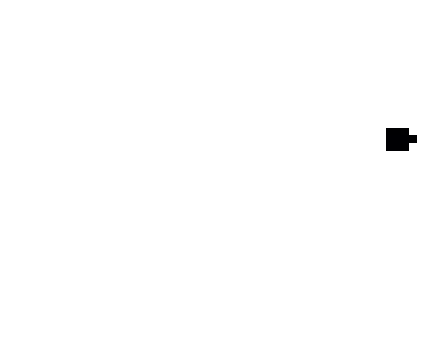

INFO:lsst.meas.deblender:Total flux: 223.311782837, max flux: 0.599749147892


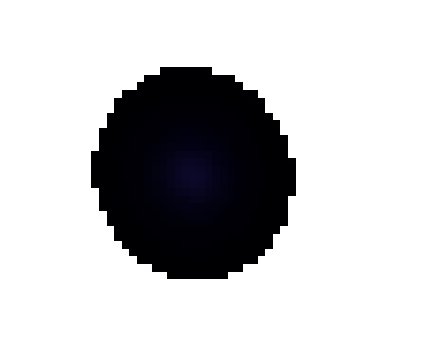

INFO:lsst.meas.deblender:Total flux: 1384.27355957, max flux: 5.56309556961


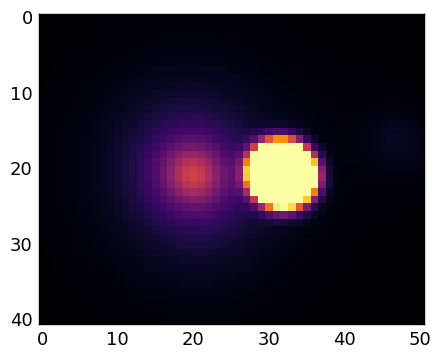

In [54]:
ttimg = np.zeros((ymax-ymin,xmax-xmin))
for match in matches:
    width = np.sqrt(match["intensity_i"].size)
    height = width
    timg = match["intensity_g"].reshape(height, width)
    ttimg += timg[ymin:ymax,xmin:xmax]
    display.maskPlot(timg[ymin:ymax,xmin:xmax], (timg<variance)[ymin:ymax,xmin:xmax], vmax=np.max(matches["intensity_i"]))
    logger.info("Total flux: {0}, max flux: {1}".format(np.sum(timg), np.max(timg)))
    plt.show()
plt.imshow(ttimg, vmax=10)
plt.show()